In [131]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

In [132]:
from pydantic import BaseModel, Field
from typing import TypedDict
from langchain_core.messages import HumanMessage, SystemMessage

class Joke_State(TypedDict):
    """This is the joke generate Schema."""
    query: str = Field(description="User query to generate the joke based on the user query.")
    response: str = Field(description="This joke is produced by the model.")
    joke_sentiment: str = Field(description="the sentiment of the joke like is it good or bad.")

In [133]:
class Joke(TypedDict):
    """This is use for to produced structured output of the joke."""
    joke: str = Field(description="This is joke and its produced based on the user query.")

In [134]:
from typing import Literal
class EvaluatorState(TypedDict):
    """this schema is use for to evaluate the joke is good or bad"""
    sentiment: Literal['good', "bad"] = Field(description="if joke is very good the output will be good other wise output will be bad")

In [135]:
def joke_generator(state:Joke_State):
    print("joke_generator")
    """This function is responsible for to generate the best joke on the user query."""
    system_msg = "Think you are a standup comedian, ang can produce best joke for your audience."
    
    response = llm.with_structured_output(Joke).invoke([SystemMessage(content=system_msg)]+state["query"])
    # print(response['joke'])
    return {
        "response": response['joke']
    }

In [136]:
def evaluator(state: Joke_State):
    # print('evelator')
    """This function is responsible for to evaluate the joke is good or bad"""
    joke = state['response']
    # print(joke)
    system_msg = f"Think you are a joke evaluator. Evaluate this joke: {joke} if this joke is good the say good if not then say bad. and follow output schema like structured output."
    
    result = llm.with_structured_output(EvaluatorState).invoke([SystemMessage(content=system_msg)])
    # print(result['sentiment'])
    return {
        'joke_sentiment': result["sentiment"]
    }

In [137]:

from langgraph.graph import START, END, StateGraph
def router(state: Joke_State):
    print('router')
    """this is a router to route the node"""
    
    if state['joke_sentiment'] == "good":
        return 'Accepted'
    return "Rejected"

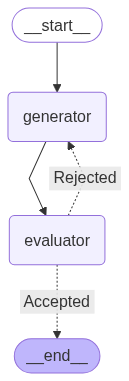

In [138]:

from IPython.display import Image, display

builder = StateGraph(Joke_State)

builder.add_node("generator", joke_generator)
builder.add_node('evaluator', evaluator)

builder.add_edge(START, 'generator')
builder.add_edge('generator', 'evaluator')
builder.add_conditional_edges('evaluator', router, {"Accepted": END, "Rejected": "generator"})
# builder.add_edge('evaluator', END)

graph = builder.compile()

## displaying
display(Image(graph.get_graph().draw_mermaid_png()))



In [139]:
## Testing
graph.invoke(
    {
        'query': [HumanMessage(content="can you generate a joke about the Agentic ai topics.")]
    }
)

joke_generator
router


{'query': [HumanMessage(content='can you generate a joke about the Agentic ai topics.', additional_kwargs={}, response_metadata={})],
 'response': 'Why did the Agentic AI go to therapy? Because it was struggling to make decisions on its own and kept acting like it had a lot of agency!',
 'joke_sentiment': 'good'}

In [140]:
## Testing
response = graph.invoke(
    {
        'query': [HumanMessage(content="can you generate a joke about the CSE.")]
    }
)

response['response']

joke_generator
router


"Why did the CSE go to therapy? Because it had a lot of 'encrypted' emotions!"